<img src="https://dootoo.app/images/thoughtswork_banner.png"/>

# DataTalks.club MLOps Zoomcamp Final Project: Task Completion Prediction

* **Author:** Paul Tongyoo
* **Contact:** Message me on <a href="https://www.linkedin.com/in/paultongyoo/">LinkedIn</a>
* **Date:** July 7, 2025
* **MLOps Zoomcamp Info:** <a href="https://datatalks.club/blog/mlops-zoomcamp.html">MLOps Zoomcamp: MLOps Course & Certification</a>

## Table of Contents

1. [Project Summary](#Project-Summary)
    1. [What I Did](#What-I-Did)
    1. [What I Learned](#What-I-Learned)
    1. [Next Steps](#Next-Steps)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Public Status](#Public-Status)

## Project Summary

In [1]:
# TODO

### What I Did

In [2]:
# TODO

### What I Learned

In [3]:
# TODO

### Next Steps

In [4]:
# TODO

-------------

In [26]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Source Data

In [11]:
# Load environment variables from .env file
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

db_url = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(db_url)
tasks_df = pd.read_sql("SELECT * FROM public.\"Item\"", engine)

In [12]:
tasks_df.shape

(2481, 21)

In [13]:
tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      2481 non-null   int64         
 1   user_id                 2481 non-null   int64         
 2   is_child                2481 non-null   bool          
 3   rank_idx                2481 non-null   int64         
 4   is_done                 2481 non-null   bool          
 5   createdAt               2481 non-null   datetime64[ns]
 6   updatedAt               2481 non-null   datetime64[ns]
 7   is_deleted              2481 non-null   bool          
 8   uuid                    2481 non-null   object        
 9   text                    2481 non-null   object        
 10  embedding               2396 non-null   object        
 11  parent_item_id          675 non-null    float64       
 12  event_id                39 non-null     object  

### Data Set Creation

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    tasks_df.drop(columns=['is_done']),
    tasks_df['is_done'],
    test_size=0.2,
    random_state=42,
    stratify=tasks_df['is_done'])

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1984, 20), (497, 20), (1984,), (497,))

## Exploratory Data Analysis

### Target Analysis ("is_done")

* Task completion rate is 27% completed
* Class imbalance necessitates tuning for both Precision and Recall, with model likely biased towards majority (`is_done==0`) class

Mean Task Completion Rate: is_done    0.270859
dtype: float64


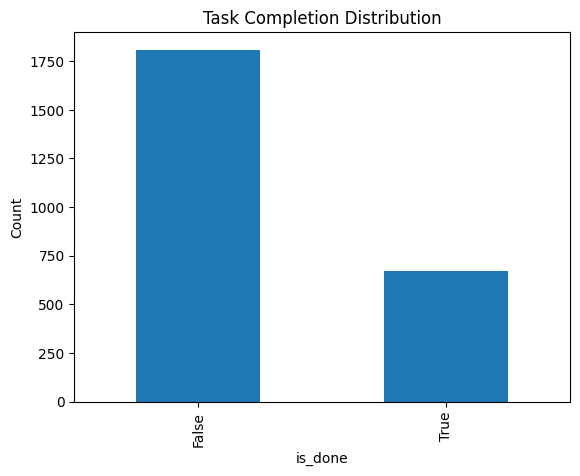

In [20]:
print(f"Mean Task Completion Rate: {tasks_df[['is_done']].mean()}")
tasks_df['is_done'].value_counts().plot(kind='bar', title='Task Completion Distribution')
plt.xlabel('is_done')
plt.ylabel('Count')
plt.show()

### Parent/Child Status

In [25]:
tasks_df.drop(columns=['is_child'], inplace=True) # Drop 'is_child' as it was deprecated in favor of 'parent_item_id'

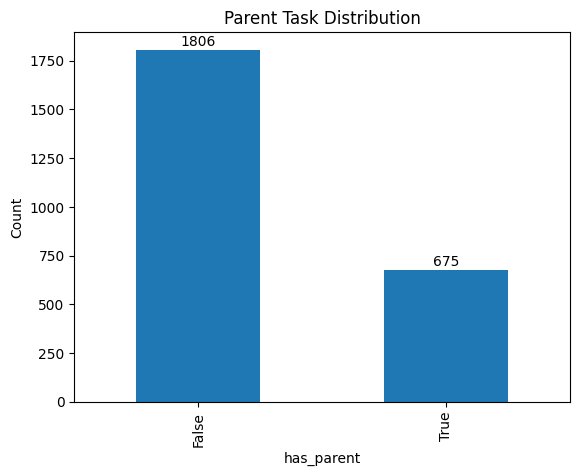

In [41]:
tasks_df['has_parent'] = tasks_df['parent_item_id'].notnull()
counts = tasks_df['has_parent'].value_counts()
counts.plot(kind='bar', title='Parent Task Distribution')
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha='center')
plt.xlabel('has_parent')
plt.ylabel('Count')
plt.show()

### Public Status

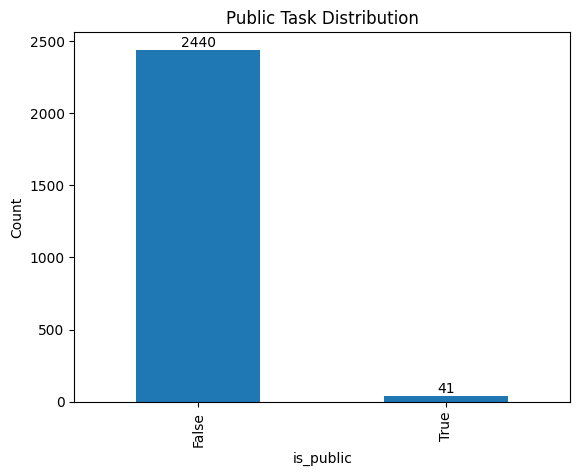

In [38]:
counts = tasks_df['is_public'].value_counts()
counts.plot(kind='bar', title='Public Task Distribution')
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha='center')
plt.xlabel('is_public')
plt.ylabel('Count')
plt.show()

------

##### Table of Contents Generator (Ignore)

In [31]:
import json
import re

def slugify(text):
    text = text.strip()
    text = re.sub(r'[^\w\s\-]', '', text)  # allow (), - and alphanumerics
    return re.sub(r'[\s]+', '-', text)

def extract_headings(ipynb_path):
    with open(ipynb_path, 'r', encoding='utf-8') as f:
        nb = json.load(f)

    toc_lines = [] # ["## Table of Contents\n"]
    for cell in nb['cells']:
        if cell['cell_type'] == 'markdown':
            for line in cell['source']:
                match = re.match(r'^(#{2,6})\s+(.*)', line)
                if match:
                    level = len(match.group(1)) - 1  # offset for nesting
                    title = match.group(2).strip()
                    anchor = slugify(title)
                    indent = '    ' * (level - 1)
                    toc_lines.append(f"{indent}1. [{title}](#{anchor})")

    return '\n'.join(toc_lines)

# Example usage:
toc = extract_headings("dootoo_item_prediction.ipynb")
print(toc)

1. [Table of Contents](#Table-of-Contents)
1. [Project Summary](#Project-Summary)
    1. [What I Did](#What-I-Did)
    1. [What I Learned](#What-I-Learned)
    1. [Next Steps](#Next-Steps)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Public Status](#Public-Status)
            1. [Table of Contents Generator (Ignore)](#Table-of-Contents-Generator-Ignore)
